# Naive Bayes – Wine Quality (binaire)

Ce notebook applique **Naive Bayes** selon les bonnes pratiques ML :
- Classificateur probabiliste simple et rapide
- Excellent baseline pour la classification
- Basé sur le théorème de Bayes avec hypothèse d'indépendance
- GaussianNB adapté aux features continues
- Suivi avec MLflow

## 1. Imports et configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
# Racine du projet (dossier contenant src/ et dataset/)
_roots = [os.getcwd(), os.path.join(os.getcwd(), '..'), os.path.join(os.getcwd(), '..', '..')]
for _r in _roots:
    _p = os.path.join(os.path.abspath(_r), 'src', 'preprocessing.py')
    if os.path.isfile(_p):
        ROOT = os.path.abspath(_r)
        sys.path.insert(0, os.path.join(ROOT, 'src'))
        break
else:
    raise FileNotFoundError("Dossier 'src' introuvable. Ouvrez le projet ML-project.")
from preprocessing import load_data, clean_data, scale_features, split_data
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("sqlite:///c:/Users/pc/Desktop/ML-project/classification/mlflow.db")
mlflow.set_experiment("wine-quality-naive-bayes")

2026/02/14 17:38:53 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/14 17:38:53 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/14 17:38:53 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/14 17:38:53 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/14 17:38:53 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/14 17:38:53 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/14 17:38:54 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/14 17:38:54 INFO alembic.runtime.migration: Will assume non-transactional DDL.


<Experiment: artifact_location='file:///C:/Users/pc/Desktop/ML-project/classification/mlruns/9', creation_time=1771085118822, experiment_id='9', last_update_time=1771085118822, lifecycle_stage='active', name='wine-quality-naive-bayes', tags={}>

## 2. Chargement et preprocessing

In [2]:
df = load_data(os.path.join(ROOT, "dataset", "winequality-red.csv"))
df = clean_data(df)

df["quality_binary"] = (df["quality"] >= 6).astype(int)

X = df.drop(columns=["quality", "quality_binary"])
y = df["quality_binary"]

X_scaled, scaler = scale_features(X)
X_train, X_test, y_train, y_test = split_data(X_scaled, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

Train: 1087, Test: 272


## 3. Entraînement du modèle

In [3]:
nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

y_proba = nb.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {acc:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"ROC-AUC: {auc_score:.3f}")
print("\nMatrice de confusion:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.732
F1-score: 0.738
ROC-AUC: 0.792

Matrice de confusion:
[[ 96  32]
 [ 41 103]]


## 4. Matrice de confusion et courbe ROC

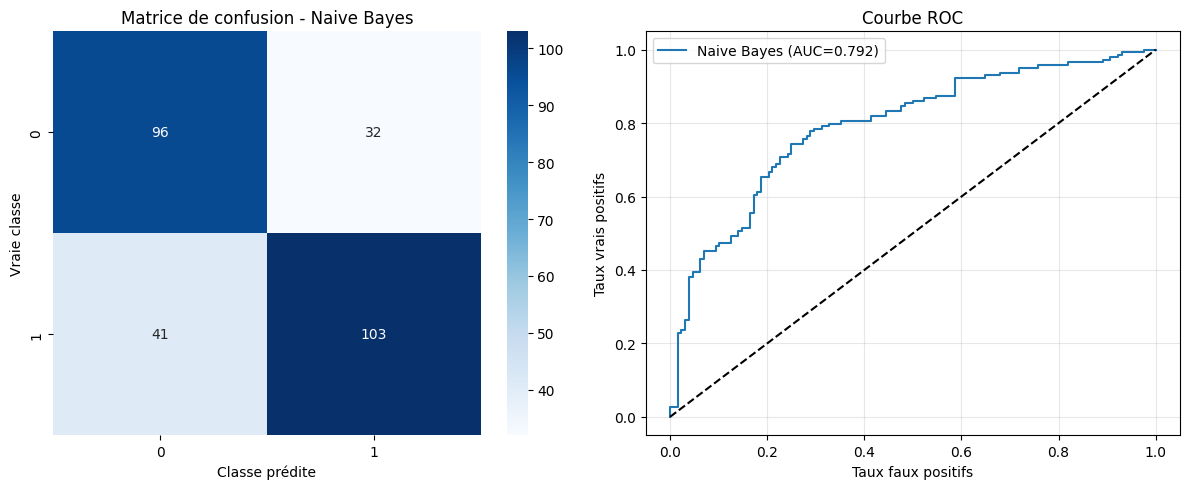

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Matrice de confusion - Naive Bayes')
axes[0].set_ylabel('Vraie classe')
axes[0].set_xlabel('Classe prédite')

fpr, tpr, _ = roc_curve(y_test, y_proba)
axes[1].plot(fpr, tpr, label=f'Naive Bayes (AUC={auc_score:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('Taux faux positifs')
axes[1].set_ylabel('Taux vrais positifs')
axes[1].set_title('Courbe ROC')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
_cwd = os.getcwd()
_project_root = os.path.dirname(_cwd) if os.path.basename(_cwd) in ('classification','clustering','reduction') else _cwd
fig_dir = os.path.join(_project_root, 'rapport', 'figures')
os.makedirs(fig_dir, exist_ok=True)
fig_path = os.path.join(fig_dir, 'naivebayes_confusion_matrix.png')
plt.savefig(fig_path)
plt.savefig('naivebayes_confusion_matrix.png')
plt.show()

## 5. MLflow tracking

In [5]:
with mlflow.start_run(run_name="NaiveBayes_binary"):
    mlflow.log_params(nb.get_params())
    mlflow.log_metric("accuracy", float(acc))
    mlflow.log_metric("f1_score", float(f1))
    mlflow.log_metric("roc_auc", float(auc_score))
    mlflow.log_metric("precision", float(precision))
    mlflow.log_metric("recall", float(recall))
    try:
        _cwd = os.getcwd()
        _proj = os.path.dirname(_cwd) if os.path.basename(_cwd) in ('classification','clustering','reduction') else _cwd
        _fig_path = os.path.join(_proj, 'rapport', 'figures', 'naivebayes_confusion_matrix.png')
        if os.path.exists(_fig_path):
            mlflow.log_artifact(_fig_path)
        elif os.path.exists('naivebayes_confusion_matrix.png'):
            mlflow.log_artifact('naivebayes_confusion_matrix.png')
    except Exception as e:
        print(f"(Artefact figure ignoré: {e})")
    mlflow.sklearn.log_model(nb, "naive_bayes_model")
    print("MLflow run terminé")

2026/02/14 17:39:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


MLflow run terminé
